In [3]:
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets

import torch.nn as nn
import torch.nn.functional as functional
import torch
!pip install torch-fidelity
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=64).cuda()

from PIL import Image
from IPython.display import display
import cv2

import random

import os

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 156MB/s] 


In [ ]:
PATH = '/kaggle/input/celeba-dataset/img_align_celeba'

In [7]:
PATH = '/kaggle/input/nimetzky'

In [8]:
transform = transforms.Compose([
    #resize the image to 64x64
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [9]:

dataset = datasets.ImageFolder(PATH, transform=transform)


### gaussian noise

In [10]:
class GaussianNoise(nn.Module):                         # Try noise just for real or just for fake images.
    def __init__(self, std=0.1, decay_rate=0):
        super().__init__()
        self.std = std
        self.decay_rate = decay_rate

    def decay_step(self):
        self.std = max(self.std - self.decay_rate, 0)

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x


### The Generator class

In [11]:
class Generator(nn.Module):
    
    DROPOUT_PERCENTAGE = 0.25
    CHANNELS = 3
    LATENT_DIM = 100
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            *self.__create_conv_layer(self.LATENT_DIM, 512, kernel_size=4, stride=1, padding=0),
            *self.__create_conv_layer(512, 256),
            *self.__create_conv_layer(256, 128),
            *self.__create_conv_layer(128, 64),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh(),
        )

        
    def __create_conv_layer(self, in_channels: int, out_channels: int, batch_norm = True, dropout = True,
                 kernel_size=4, stride=2, padding=1) -> list:
        layer = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)]

        layer.append(nn.ReLU(True))
        if batch_norm:
            layer.append(nn.BatchNorm2d(out_channels)) # TODO: check momentum

        if dropout:
            layer.append(nn.Dropout2d(self.DROPOUT_PERCENTAGE))
        
        return layer

    def forward(self, x):
        return self.model(x)

The Discriminator class

In [271]:
class Discriminator(nn.Module):
    
    LEAKY_RELU_SLOPE = 0.2
    DROPOUT_PERCENTAGE = 0.25
    CHANNELS = 3
    STARTING_SIZE = 64
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.convolutional_model = nn.Sequential(
            *self.__create_conv_layer(3, 64),
            *self.__create_conv_layer(64, 128),
            *self.__create_conv_layer(128, 256),
            *self.__create_conv_layer(256, 512),
        )
        
        self.flatten_size = self.__get_flatten_size()

        self.fully_connected_model = nn.Sequential(
            *self.__create_fully_connected_layer(self.flatten_size, 512),
            *self.__create_fully_connected_layer(512, 1),
            nn.Sigmoid()
        )
        
    def __get_flatten_size(self):
        dummy_input = torch.zeros(1, 3, self.STARTING_SIZE, self.STARTING_SIZE)
        # Pass the dummy input through the convolutional layers
        dummy_result = self.convolutional_model(dummy_input)
        # Flatten the output to calculate the size
        flatten_size = dummy_result.view(-1).size(0)
        
        return flatten_size

        
    def __create_conv_layer(self, in_channels: int, out_channels: int, batch_norm = True, dropout = True,
                 kernel_size=3, stride=2, padding=1) -> list:
        layer = [GaussianNoise(),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)]

        layer.append(nn.LeakyReLU(self.LEAKY_RELU_SLOPE, inplace=True))
        if batch_norm:
            layer.append(nn.BatchNorm2d(out_channels)) # TODO: check momentum

        if dropout:
            layer.append(nn.Dropout2d(self.DROPOUT_PERCENTAGE))
        
        return layer
        
    def __create_fully_connected_layer(self, in_features: int, out_features: int) -> list:
        layer = [nn.Linear(in_features, out_features), nn.LeakyReLU(self.LEAKY_RELU_SLOPE, inplace = True)]
        
        return layer

    def forward(self, x):
        x = self.convolutional_model(x)
        x = x.view(-1, self.flatten_size)
        x = self.fully_connected_model(x)
        
        return x


In [272]:
LEARNING_RATE_GENERATOR = 0.001
LEARNING_RATE_DISCRIMINATOR = 0.0003
MOMENTUM_B1 = 0.7
MOMENTUM_B2 = 0.999

loss_function = nn.BCELoss()
generator = Generator().cuda()
discriminator = Discriminator().cuda()

generator_optimizer = torch.optim.Adam(generator.parameters(), 
                                       lr=LEARNING_RATE_GENERATOR, betas=(MOMENTUM_B1, MOMENTUM_B2),
                                       )
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), 
                                       lr=LEARNING_RATE_DISCRIMINATOR, betas=(MOMENTUM_B1, MOMENTUM_B2),
                                        )



Load the model

In [273]:
WORKING_PATH = "/kaggle/input/fixed-dis/"

generator.load_state_dict(torch.load(os.path.join(WORKING_PATH, 'generator')))
discriminator.load_state_dict(torch.load(os.path.join(WORKING_PATH, 'discriminator')))

<All keys matched successfully>

In [ ]:
EPOCHS = 200
K = 5
BATCH_SIZE = 32

data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    for i, (real_images, _) in enumerate(data_loader):
        
        real_images = real_images.cuda()
        real_labels = torch.ones(real_images.size(0), 1).cuda()
        fake_labels = torch.zeros(real_images.size(0), 1).cuda()
        
        shape = torch.Size((real_images.size(0), Generator.LATENT_DIM, 1, 1))
        noise = (2 * torch.rand(shape, dtype=torch.float32)) - 1
        noise = noise.cuda()
        generated_images = generator(noise)
        real_output = discriminator(real_images).cuda()
        fake_output = discriminator(generated_images).cuda()
        
        real_loss = loss_function(real_output, real_labels)
        fake_loss = loss_function(fake_output, fake_labels)
        discriminator_loss = real_loss + fake_loss
        
        discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        discriminator_optimizer.step()
        
        if i % K == 0:
            noise = (2 * torch.rand(shape, dtype=torch.float32)) - 1
            noise = noise.cuda()
            generated_images = generator(noise)
            output = discriminator(generated_images)
            
            # We use real_labels because we want to maximize log(D(G(z)))
            # which is equivalent to minimizing log(1-D(G(z)))
            generator_loss = loss_function(output, real_labels)
            
            generator_optimizer.zero_grad()
            generator_loss.backward()
            generator_optimizer.step()
        
        
        if i % 150 == 0:
            generated_images_uint8 = (generated_images.data * 255).clamp(0, 255).byte()
            real_images_uint8 = (real_images.data * 255).clamp(0, 255).byte()
            
            fid.update(generated_images_uint8.data, real=True)
            fid.update(real_images_uint8.data, real=False)
            
            print(f"[Epoch {epoch}/{EPOCHS}] [Batch {i}/{len(data_loader)}] [D loss: {discriminator_loss.item()}] [G loss: {generator_loss.item()}] [FID: {fid.compute()}]")

            perm = torch.randperm(generated_images.size(0))
            idx = perm[:25]
            samples = generated_images[idx]
            
            save_image(samples, f"/kaggle/working/{epoch}_{i}.png", nrow=5, normalize=True)
            img = Image.open(f"/kaggle/working/{epoch}_{i}.png")
            display(img)
            
            torch.save(generator.state_dict(), '/kaggle/working/generator')
            torch.save(discriminator.state_dict(), '/kaggle/working/discriminator')

            

# Interpatation

In [275]:
SIZE = 64
def create_mask(x_0, y_0, x_1, y_1, size = (SIZE, SIZE)):
    arr = np.zeros(size)

    arr[x_0:x_1, y_0:y_1] = 1
    return arr

def get_ring(mask):
    ring = np.zeros_like(mask)
    kernel = np.array([[1,1,1], [1,1,1], [1,1,1]])
    for k in range(1, mask.shape[0]-1):
        if k==32:
            k=32
            pass
        new_arr = np.zeros_like(mask)
        for i in range(1, mask.shape[0]-1):
            for j in range(1, mask.shape[1]-1):
                new_arr[i,j] = min(np.sum(mask[i-1:i+2, j-1:j+2]*kernel),1)
        ring += (new_arr-mask)/(2**k)
        mask = new_arr
        
    return ring*2


In [120]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt


In [130]:
NUM_ITERATIONS = 30000

# Define the loss function
criterion = nn.L1Loss()
bce_criterion = nn.BCELoss()
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

org_mask = create_mask(32, 20, 48, 44)
# Create a 64x64 tensor filled with False
mask = np.array([get_ring(org_mask), get_ring(org_mask), get_ring(org_mask)])
mask = torch.from_numpy(mask).unsqueeze(0).cuda()

org_mask_cuda = torch.from_numpy(org_mask).unsqueeze(0).cuda()

In [299]:
import scipy as sp
import scipy.sparse.linalg

def neighbours(i: int, j: int, max_i: int, max_j: int):
    """
    Returns 4-connected neighbours for given pixel point.
    :param i: i-th index position
    :param j: j-th index position
    :param max_i: max possible i-th index position 
    :param max_j: max possible j-th index position 
    """
    pairs = []
    
    for n in [-1, 1]:
        if 0 <= i+n <= max_i:
            pairs.append((i+n, j))
        if 0 <= j+n <= max_j:
            pairs.append((i, j+n))
    
    return pairs
def blend(
    img_s: np.ndarray, 
    mask: np.ndarray, 
    img_t: np.ndarray
) -> np.ndarray:
    """
    Returns a Poisson blended image with masked img_s over the img_t.
    :param img_s: the image containing the foreground object (-1 to 1 range)
    :param mask: the mask of the foreground object in object_img
    :param img_t: the background image (-1 to 1 range)
    """
    img_s_h, img_s_w = img_s.shape
        
    nnz = (mask > 0).sum()
    im2var = -np.ones(mask.shape[0:2], dtype='int32')
    im2var[mask > 0] = np.arange(nnz)
    
    ys, xs = np.where(mask == 1) 
        
    A = sp.sparse.lil_matrix((4 * nnz, nnz))
    b = np.zeros(4 * nnz)
    
    e = 0
    for n in range(nnz):
        y, x = ys[n], xs[n]  
        
        for n_y, n_x in neighbours(y, x, img_s_h - 1, img_s_w - 1):
            A[e, im2var[y][x]] = 1
            b[e] = img_s[y][x] - img_s[n_y][n_x]
            
            if im2var[n_y][n_x] != -1:
                A[e, im2var[n_y][n_x]] = -1
            else:
                b[e] += img_t[n_y][n_x]
            e += 1
    
    A = sp.sparse.csr_matrix(A)
    v = sp.sparse.linalg.lsqr(A, b)[0]
    
    img_t_out = img_t.copy()
    
    for n in range(nnz):
        y, x = ys[n], xs[n]
        img_t_out[y][x] = v[im2var[y][x]]
    
    return img_t_out


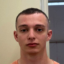

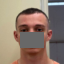

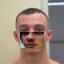

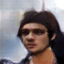

Iteration [1/30000], Loss: 1.9621452380985343
tensor(1.9163, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0459, device='cuda:0', grad_fn=<MulBackward0>) tensor([[0.3997]], device='cuda:0', grad_fn=<SigmoidBackward0>)


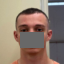

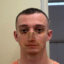

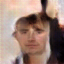

Iteration [1001/30000], Loss: 0.29768753732977704
tensor(0.2956, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>) tensor([[0.9588]], device='cuda:0', grad_fn=<SigmoidBackward0>)


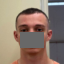

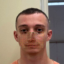

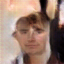

Iteration [2001/30000], Loss: 0.28007444082565913
tensor(0.2788, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0013, device='cuda:0', grad_fn=<MulBackward0>) tensor([[0.9742]], device='cuda:0', grad_fn=<SigmoidBackward0>)


KeyboardInterrupt: 

In [348]:
# load image
for i, (real_images, _) in enumerate(data_loader):
    img = real_images.cuda()
    break
    
masked_img = img * mask
original_blacked_img = img.cpu() * (1-org_mask)
original_blacked_img = original_blacked_img.cuda()
    
# show image
save_image(img, f"/kaggle/working/temp.png", nrow=5, normalize=True)
disp_img = Image.open(f"/kaggle/working/temp.png")
display(disp_img)

# Initialize the latent vector z with random noise
noise = (2 * torch.rand((1, Generator.LATENT_DIM, 1, 1), dtype=torch.float32)) - 1
noise = noise.cuda()
noise.requires_grad = True  # Ensure gradients are tracked


# Set up the optimizer for z
optimizer = torch.optim.Adam([noise], lr=0.1)

# Define the number of iterations for optimization

lambda_recon = 100.0
lambda_adv = 0.05

generator.eval()
discriminator.eval()

for iteration in range(NUM_ITERATIONS):
    optimizer.zero_grad()
    # Generate an image from the latent vector z
    generated_img = generator(noise)
    discriminator_output = discriminator(generated_img)
    # Compute the loss between the generated image and the corrupted image
    recon_loss = criterion(generated_img * mask, masked_img)
    
    adv_loss = bce_criterion(discriminator_output, torch.ones_like(discriminator_output))
    # Total loss
    loss = lambda_recon * recon_loss + lambda_adv * adv_loss
    # Backpropagate the loss
    loss.backward()

    # Update the latent vector z
    optimizer.step()

    # Print the loss every 1000 iterations
    if (iteration) % 1000 == 0:
        # Apply the mask        
        generated_img_masked = generated_img.clone()
        generated_img_masked *= org_mask_cuda
        generated_img_masked += original_blacked_img
        
        
        save_image(original_blacked_img, f"/kaggle/working/temp.png", nrow=5, normalize=True)
        disp_img = Image.open(f"/kaggle/working/temp.png")
        display(disp_img)
        save_image(generated_img_masked, f"/kaggle/working/final_{iteration}.png", nrow=5, normalize=True)
        disp = Image.open(f"/kaggle/working/final_{iteration}.png")
        display(disp)
        save_image(generated_img, f"/kaggle/working/temp.png", nrow=5, normalize=True)
        disp_img = Image.open(f"/kaggle/working/temp.png")
        display(disp_img)
        print(f"Iteration [{iteration+1}/{NUM_ITERATIONS}], Loss: {loss.item()}")
        print(lambda_recon * recon_loss, lambda_adv * adv_loss, discriminator(generated_img))
